In [36]:
import os, sys
import argparse
import numpy as np
import healpy as hp
from iminuit import Minuit
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits

# Fermi plugin path
sys.path.append("/group/hepheno/heptools/Fermi-NPTF-exposure/") 
import fermi.fermi_plugin as fp

# NPTFit modules
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import dnds_analysis # module for analysing the output

%matplotlib inline

In [37]:
catalog = pd.read_csv("../GenerateJFactors/DarkSky_ALL_200,200,200_v3.csv")

In [38]:
# Feynman dirs
work_dir = '/group/hepheno/smsharma/Fermi-LSS/'
psf_dir='/mnt/hepheno/CTBCORE/psf_data/'
maps_dir='/mnt/hepheno/CTBCORE/'
fermi_data_dir='/mnt/hepheno/FermiData/'
data_folder='/tigress/Fermi-LSS/AdditionalData/'

In [39]:
# Global settings
nside=128
eventclass=5 # 2 (Source) or 5 (UltracleanVeto)
eventtype=0 # 0 (all), 3 (bestpsf) or 5 (top3 quartiles)
diff = 'p7' # 'p6', 'p7', 'p8'
emin = 0
emax = 39

print "Loading Fermi plugin and templates"

# Load the Fermi plugin
f_global = fp.fermi_plugin(maps_dir,fermi_data_dir=fermi_data_dir,work_dir=work_dir,CTB_en_min=emin,CTB_en_max=emax+1,nside=nside,eventclass=eventclass,eventtype=eventtype,newstyle=1,data_July16=True)

Loading Fermi plugin and templates


In [40]:
# Load necessary templates
f_global.add_diffuse_newstyle(comp = diff,eventclass = eventclass, eventtype = eventtype) 
f_global.add_iso()  
# f_global.add_ps_model()
ps_temp = np.load('ps_map.npy')
f_global.add_template_by_hand(comp='ps_model',template=ps_temp)
f_global.add_bubbles() 

In [41]:
# ######
# ###input: n is number of model parameters, ll is the likelihood function that takes as input 
# #####ll([x1,x2,...,xn])
# ####convert ll function into form necessary for iminuit
# class fake_code:
#     def __init__(self, n,var_names=['False']):
#         self.co_argcount = n
#         if var_names[0] != 'False':
#             self.co_varnames = tuple(var_names)
#         else:
#             self.co_varnames = tuple(map(str, range(n)))

# class call_ll:
#     def __init__(self, n,ll,var_names=['False']):
#         self.n = n
#         self.func_code = fake_code(n,var_names=var_names)
#         self.ll = ll
#     def __call__(self, *args):
#         return - self.ll([arg for arg in args])


In [42]:
iobj = 8

l = catalog.l.values[iobj]
b = catalog.b.values[iobj]

In [43]:
# ls_mask_load = fits.open('Allpscmask_3FGL-energy0.20000000large-obj.fits')
# ls_mask = np.array([np.round(val) for val in hp.ud_grade(ls_mask_load[0].data,128,power=0)])

In [9]:
for iebin, ebin in enumerate(np.arange(emin,emax)):

    mc_file = np.load("/mnt/hepheno/FermiMC_NewPS/MC_allhalos_p7_nodm_nops_v0.npy")[ebin]

    fermi_data = f_global.CTB_count_maps[iebin].astype(np.int32)
    fermi_exposure = f_global.CTB_exposure_maps[iebin]

    dif = f_global.template_dict[diff][iebin]
    iso = f_global.template_dict['iso'][iebin]
    psc = f_global.template_dict['ps_model'][iebin]
    bub = f_global.template_dict['bubs'][iebin]

    #######################
    # NPTFit fit as usual #
    #######################

    n = nptfit.NPTF(tag='poiss_bin_'+str(ebin))
    n.load_data(mc_file, fermi_exposure)

    # Mask used in analysis
    analysis_mask = cm.make_mask_total(mask_ring = True, inner = 0, outer = 10, ring_b = b, ring_l = l)
    n.load_mask(analysis_mask)

    n.add_template(dif, diff)
    n.add_template(iso, 'iso')
    n.add_template(psc, 'psc')
    n.add_template(bub, 'bub')

    n.add_poiss_model(diff, '$A_\mathrm{dif}$', [0,10], False)
    n.add_poiss_model('iso', '$A_\mathrm{iso}$', [0,20], False)
    # n.add_poiss_model('psc', '$A_\mathrm{psc}$', [0,10], False)
    n.add_poiss_model('bub', '$A_\mathrm{bub}$', [0,10], False)

    n.configure_for_scan()
    n.perform_scan(nlive=200)

The number of parameters to be fit is 3


In [10]:
n.templates_dict

{'bub': array([ 0.,  0.,  0., ...,  0.,  0.,  0.]),
 'iso': array([ 0.96301928,  0.96486827,  0.96017107, ...,  0.90815853,
         0.91045385,  0.9116891 ]),
 'p7': array([ 3.17355517,  3.23485092,  3.23692431, ...,  3.57943559,
         3.63235772,  3.62761766]),
 'psc': array([ 0.4363409 ,  0.40910679,  0.44553799, ...,  0.6936664 ,
         0.46256119,  0.40383089])}

In [11]:
for key in n.templates_dict.keys():
    print key, np.sum(n.templates_dict[key])

bub 19146.0919143
psc 840111.314049
iso 196608.0
p7 5825583.96286


In [12]:
n.exposure_map

array([  1.37148506e+11,   1.37411838e+11,   1.36742879e+11, ...,
         1.29335509e+11,   1.29662403e+11,   1.29838318e+11], dtype=float32)

In [13]:
np.sum(analysis_mask)

195116

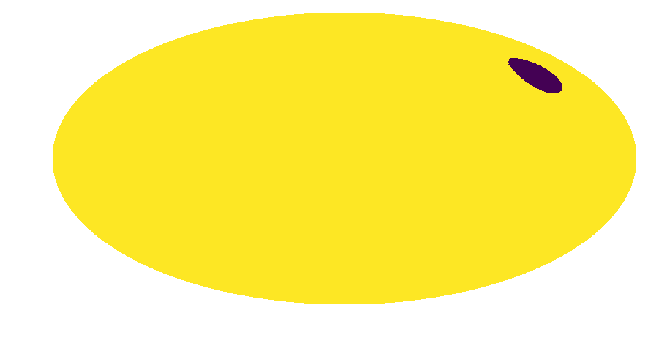

In [14]:
hp.mollview(analysis_mask, title='', cbar=False, min=0,max=1)

In [15]:
n.perform_scan(nlive=200)

In [16]:
n.load_scan()

  analysing data from /group/hepheno/smsharma/Fermi-LSS/Notebooks/chains/poiss_bin_2/.txt


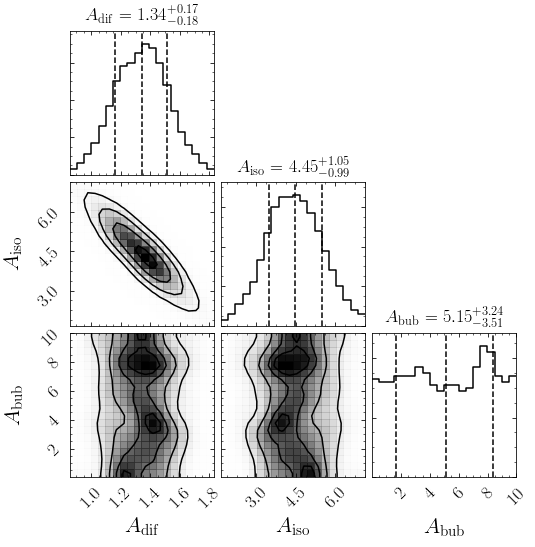

In [17]:
an = dnds_analysis.Analysis(n)
an.make_triangle()

In [21]:
keys = n.poiss_model_keys
limit_dict = {}
init_val_dict = {}
step_size_dict = {}
for key in keys:
    limit_dict['limit_'+key] = (0,200)
    init_val_dict[key] = 0.0
    step_size_dict['error_'+key] = 1
other_kwargs = {'print_level': 1}
z = limit_dict.copy()
z.update(other_kwargs)
z.update(limit_dict)
z.update(init_val_dict)
z.update(step_size_dict)
f = call_ll(len(keys),n.ll,keys)
m = Minuit(f,errordef=1,**z)
m.migrad()

FCN = 3889.15428272 
 TOTAL NCALL = 150 
 NCALLS = 150 
 
 
 EDM = 5.32761649442e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Parab Error,Minos Error-,Minos Error+,Limit-,Limit+,FIXED
1,p7,1.34756,0.252844,0,0,0.0,200.0,
2,iso,4.42419,1.44855,0,0,0.0,200.0,
3,bub,0.000190735,142.106,0,0,0.0,200.0,


({'hesse_failed': False, 'has_reached_call_limit': False, 'has_accurate_covar': True, 'has_posdef_covar': True, 'up': 1.0, 'edm': 5.327616494418818e-06, 'is_valid': True, 'is_above_max_edm': False, 'has_covariance': True, 'has_made_posdef_covar': False, 'has_valid_parameters': True, 'fval': 3889.154282716574, 'nfcn': 150},
 [{'is_const': False, 'name': 'p7', 'has_limits': True, 'value': 1.3475627405038715, 'number': 0, 'has_lower_limit': True, 'upper_limit': 200.0, 'lower_limit': 0.0, 'has_upper_limit': True, 'error': 0.2528444571306021, 'is_fixed': False},
  {'is_const': False, 'name': 'iso', 'has_limits': True, 'value': 4.424186127277152, 'number': 1, 'has_lower_limit': True, 'upper_limit': 200.0, 'lower_limit': 0.0, 'has_upper_limit': True, 'error': 1.4485524239212344, 'is_fixed': False},
  {'is_const': False, 'name': 'bub', 'has_limits': True, 'value': 0.00019073480265197063, 'number': 2, 'has_lower_limit': True, 'upper_limit': 200.0, 'lower_limit': 0.0, 'has_upper_limit': True, 'e

In [22]:
{'bubs-0': 0.36467542146704018,
 'iso-0': 5.7371720990918131,
 'p7-0': 1.1078225788386411,
 'ps_model-0': 0.97248731692148904}
In [141]:


SyntaxError: invalid syntax (<ipython-input-22-1e6581b4f69e>, line 5)

In [23]:
bkg_sum = np.zeros(len(mc_file))
for key in keys:
    bkg_sum += n.templates_dict[key]*m.values[key]

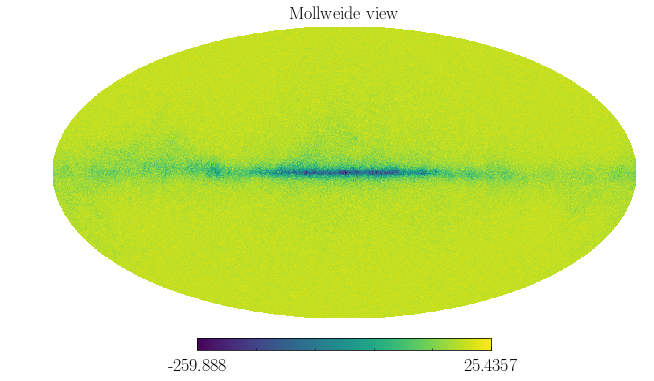

In [24]:
hp.mollview(mc_file - bkg_sum)

In [25]:
# Load in the 3FGL catalog 
source_3fg_df = pd.read_csv('/group/hepheno/smsharma/Fermi-High-Latitudes/Fermi-HighLat/sim_new/data/3fgl.dat', sep='|', comment='#')

In [26]:
# Remove whitespace from column names
source_3fg_df.rename(columns=lambda x: x.strip(), inplace=True)
for col in source_3fg_df.columns.values:
    try:
        source_3fg_df[col] = source_3fg_df[
            col].map(str.strip)
    except TypeError:
        continue

# Convert to numeric data
source_3fg_df = source_3fg_df.convert_objects(
    convert_numeric=True)

/group/hepheno/heptools/anaconda3/envs/venv_py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


Sigma is 25.479654 arcmin (0.007412 rad) 
-> fwhm is 60.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


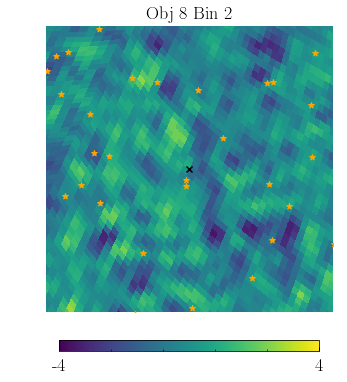

In [27]:
oFig1 = plt.figure(1,figsize=(10,80))

lbrange = 10
iobj = 10

for ie in (range(1)):
#     oFig1.add_subplot(2,2,ie+1)
#     the_map = hp.ma(np.load("../../../AdditionalData/residuals_virgo_mcfly//res_mcfly_i_0_E_"+str(ie)+".npy"))

    # the_map.mask = hp.ud_grade(f_global.ps_mask_array[10] , 128, power=-2) > 0
#     for idx, [l, b] in enumerate(zip(dftop['l'],dftop['b'])[:1]):
    hp.cartview(hp.smoothing(bkg_sum - mc_file,1.*np.pi/180.), min=-4,max=4, rot=(catalog['l'].values[iobj],catalog['b'].values[iobj]), lonra=[-lbrange,lbrange],latra=[-lbrange,lbrange], title="Obj 8 Bin 2")
#     hp.graticule()

    l = np.array([catalog['l'].values[iobj]])
    b = np.array([catalog['b'].values[iobj]])
    
    hp.projscatter(l, b, lonlat=True, coord='G', marker='x', color='k')


    l = source_3fg_df['_Lii']
    b = source_3fg_df['_Bii']

    hp.projscatter(l, b, lonlat=True, coord='G', marker='*', color='orange')
